In [1]:
import os
from datetime import datetime, timedelta, timezone
from skyfield.api import load, Topos, EarthSatellite
import matplotlib.pyplot as plt
import numpy as np

# all satellite TLE directory
directory = 'TLE_data/'
output_file = "Starlink_TLE/TLE_history.txt"

In [2]:
def parse_tle_epoch(epoch):
    year = int(epoch[:2])
    if year < 57:
        year += 2000
    else:
        year += 1900
    day_of_year = float(epoch[2:])
    day = int(day_of_year)
    fractional_day = day_of_year - day
    date = datetime(year, 1, 1, tzinfo=timezone.utc) + timedelta(days=day - 1)
    time_of_day = timedelta(days=fractional_day)
    return date + time_of_day



# checj if TLE in the time range
def is_tle_in_date_range(tle, start_date, end_date):
    epoch = tle.split()[3]
    tle_time = parse_tle_epoch(epoch)
    return start_date <= tle_time <= end_date

In [3]:
# Dictyionary to store all starlink TLE data
starlink_tle_data = {}

# define time range
start_date = datetime(2024, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2024, 2, 1, tzinfo=timezone.utc)

# search all TLE data in history
for filename in os.listdir(directory):
    if filename.startswith('satellite_TLE'):
        filepath = os.path.join(directory, filename)
        #print(filepath)

        # read file content
        with open(filepath, 'r') as file:
            lines = file.readlines()
            
            # extract starlink satellite TLE
            i = 0
            while i < len(lines):
                if lines[i].startswith('0 STARLINK'):
                    satellite_name = lines[i].strip().split(' ', 1)[1]  # remove the beginning number and space
                    tle1 = lines[i+1].strip()
                    tle2 = lines[i+2].strip()
                    if is_tle_in_date_range(tle1, start_date, end_date):
                        if satellite_name not in starlink_tle_data:
                            starlink_tle_data[satellite_name] = []
                        starlink_tle_data[satellite_name].append(f'{satellite_name}\n{tle1}\n{tle2}\n')
                    i += 3
                else:
                    i += 1

In [10]:
def get_oldest_tle(tle_list, target_time):
    oldest_tle = None
    oldest_time = None
    for tle in tle_list:
        epoch = tle.split()[4]
        #print(epoch)
        tle_time = parse_tle_epoch(epoch)
        if tle_time >= target_time:
            if oldest_time is None or tle_time < oldest_time:
                oldest_tle = tle
                old_time = tle_time
    return oldest_tle

In [88]:
# Function to extract orbital parameters from a satellite object
def extract_orbital_parameters(satellite, target_time):
    
    geocentric = satellite.at(target_time)
    subpoint = geocentric.subpoint()
    altitude = subpoint.elevation.km
    return {
        'inclination': np.degrees(satellite.model.inclo),
        'raan': np.degrees(satellite.model.nodeo),
        'altitude': altitude,
        'perigee': np.degrees(satellite.model.argpo),
        'mean_anomaly': np.degrees(satellite.model.mo),
        'mean_motion': satellite.model.no * (1440 / (2 * 3.141592653589793)),
        'eccentricity': satellite.model.ecco,
        'drag_term': satellite.model.bstar
    }

In [102]:
ts = load.timescale()
satellite_data = {}

target_time = ts.utc(2024, 1, 1, 0, 0, 0)  # 例如2024年5月1日12:00 UTC
for satellite_name, tles in starlink_tle_data.items():
    oldest_tle = get_oldest_tle(tles, target_time.utc_datetime())
    if oldest_tle:
        #print(satellite_name)
        #print(satellite_name)
        satellite = EarthSatellite(oldest_tle.split('\n')[1], oldest_tle.split('\n')[2], satellite_name, ts)
        
        # Extract orbital parameters
        parameters = extract_orbital_parameters(satellite, target_time)
        # Check if altitude is within the range [500, 600] km
        if 500 <= parameters['altitude'] <= 600:
            satellite_data[satellite_name] = parameters

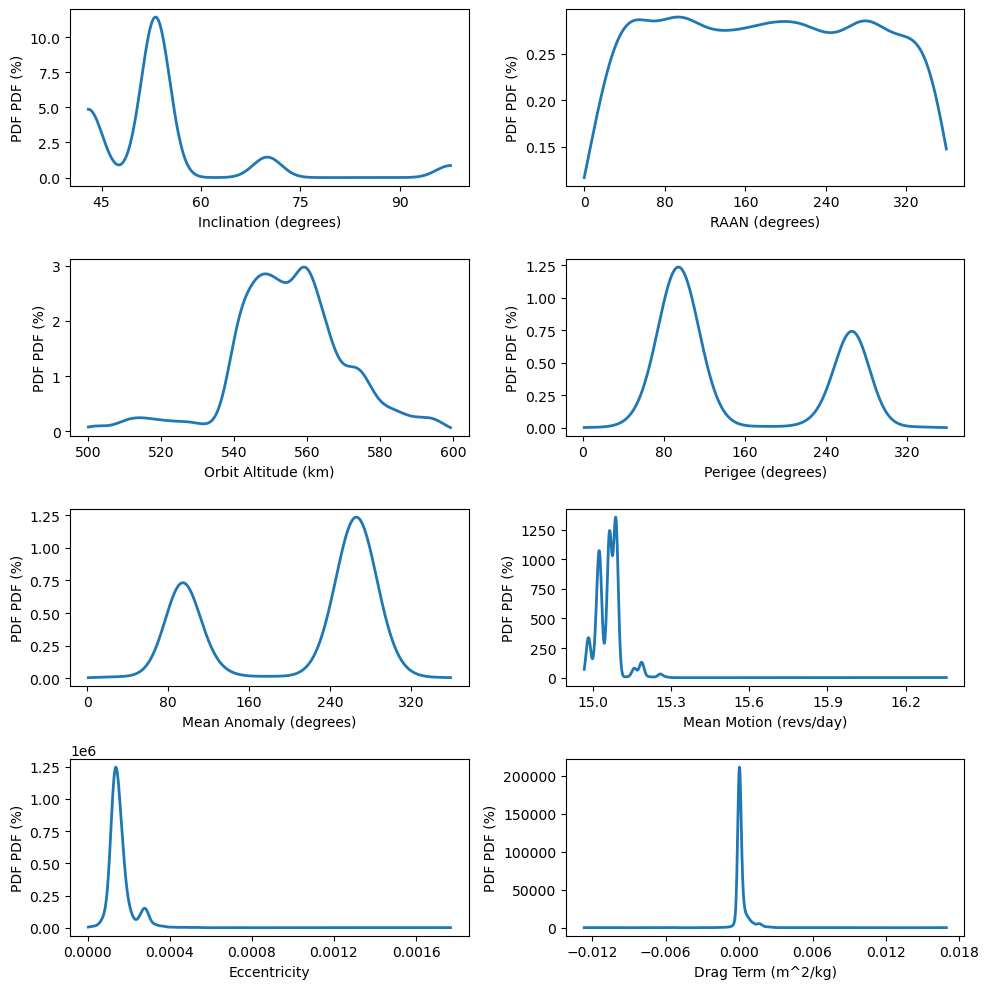

PDF Plots generated for Inclination, Right Ascension, Orbit Altitude, Perigee, Mean Anomaly, Mean Motion, Eccentricity, Drag Term, and RAAN.


In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import MaxNLocator

# Function to plot PDF distribution using Gaussian KDE
def plot_pdf(ax, data, title, xlabel):
    if len(data) == 0:
        print(f"No data available for {title}. Skipping plot.")
        return
    
    if not np.isfinite(data).all():
        print(f"Data contains NaN or infinite values for {title}. Skipping plot.")
        return
    
    # Calculate Gaussian KDE
    kde = gaussian_kde(data, bw_method='scott')  # bw_method can be 'scott' or 'silverman' for automatic bandwidth
    x = np.linspace(min(data), max(data), 1000)  # Generate 1000 points between the min and max of the data
    y = kde(x) * 100   # Evaluate the PDF at each x

    # Plot the PDF
    ax.plot(x, y, lw=2)
    #ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('PDF PDF (%)')
    
    # Set x-axis tick locator to control tick density
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust 'nbins' to set desired number of ticks
    
    ax.grid(False)

# Example usage (integrate this part into your main code)
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

# Replace the below example lists with your actual data
inclinations = [v['inclination'] for v in satellite_data.values()]
raans = [v['raan'] for v in satellite_data.values()]
altitudes = [v['altitude'] for v in satellite_data.values()]
perigees = [v['perigee'] for v in satellite_data.values()]
mean_anomalies = [v['mean_anomaly'] for v in satellite_data.values()]
mean_motions = [v['mean_motion'] for v in satellite_data.values()]
eccentricities = [v['eccentricity'] for v in satellite_data.values()]
drag_terms = [v['drag_term'] for v in satellite_data.values()]

# Plot each parameter separately using the updated plot_pdf function
plot_pdf(axs[0, 0], inclinations, 'Inclination Distribution', 'Inclination (degrees)')
plot_pdf(axs[0, 1], raans, 'RAAN Distribution', 'RAAN (degrees)')
plot_pdf(axs[1, 0], altitudes, 'Orbit Altitude Distribution', 'Orbit Altitude (km)')
plot_pdf(axs[1, 1], perigees, 'Perigee Distribution', 'Perigee (degrees)')
plot_pdf(axs[2, 0], mean_anomalies, 'Mean Anomaly Distribution', 'Mean Anomaly (degrees)')
plot_pdf(axs[2, 1], mean_motions, 'Mean Motion Distribution', 'Mean Motion (revs/day)')
plot_pdf(axs[3, 0], eccentricities, 'Eccentricity Distribution', 'Eccentricity')
plot_pdf(axs[3, 1], drag_terms, 'Drag Term Distribution', 'Drag Term (m^2/kg)')

plt.tight_layout()
plt.show()

print('PDF Plots generated for Inclination, Right Ascension, Orbit Altitude, Perigee, Mean Anomaly, Mean Motion, Eccentricity, Drag Term, and RAAN.')



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

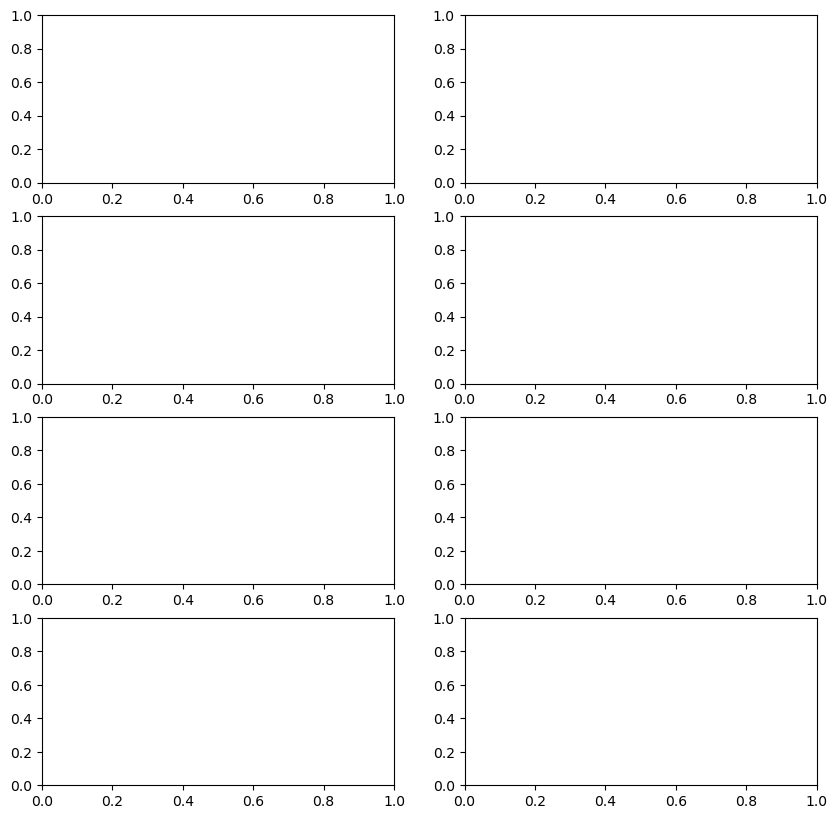

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import MaxNLocator

# Function to plot PDF distribution using Gaussian KDE
def plot_pdf(ax, data, title, xlabel):
    if len(data) == 0:
        print(f"No data available for {title}. Skipping plot.")
        return
    
    if not np.isfinite(data).all():
        print(f"Data contains NaN or infinite values for {title}. Skipping plot.")
        return
    
    # Calculate Gaussian KDE
    kde = gaussian_kde(data, bw_method='scott')  # bw_method can be 'scott' or 'silverman' for automatic bandwidth
    x = np.linspace(min(data), max(data), 100)  # Generate 1000 points between the min and max of the data
    kde_pdf = kde(x) * 100  # Convert to percentage if desired
    
    # Calculate Normal PDF based on data mean and std
    normal_pdf = norm.pdf(x, loc=np.mean(data), scale=np.std(data)) * 100
    
    # Plot the histogram
    ax.hist(data, bins=30, density=True, alpha=0.6, color='b', label='Histogram')
    
    # Plot the PDFs
    #ax.plot(x, kde_pdf, 'g', label='KDE PDF')  # Gaussian KDE PDF
    ax.plot(x, normal_pdf, 'r', linestyle='--', label='Normal PDF')  # Normal PDF
    
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density (%)')
    ax.set_title(title)
    ax.legend()
    
    # Set x-axis tick locator to control tick density
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    
    ax.grid(False)

# Example usage (integrate this part into your main code)
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

# Replace the below example lists with your actual data
inclinations = [v['inclination'] for v in satellite_data.values()]
raans = [v['raan'] for v in satellite_data.values()]
altitudes = [v['altitude'] for v in satellite_data.values()]
perigees = [v['perigee'] for v in satellite_data.values()]
mean_anomalies = [v['mean_anomaly'] for v in satellite_data.values()]
mean_motions = [v['mean_motion'] for v in satellite_data.values()]
eccentricities = [v['eccentricity'] for v in satellite_data.values()]
drag_terms = [v['drag_term'] for v in satellite_data.values()]

# Plot each parameter separately using the updated plot_pdf function
plot_pdf(axs[0, 0], inclinations, 'Inclination Distribution', 'Inclination (degrees)')
plot_pdf(axs[0, 1], raans, 'RAAN Distribution', 'RAAN (degrees)')
plot_pdf(axs[1, 0], altitudes, 'Orbit Altitude Distribution', 'Orbit Altitude (km)')
plot_pdf(axs[1, 1], perigees, 'Perigee Distribution', 'Perigee (degrees)')
plot_pdf(axs[2, 0], mean_anomalies, 'Mean Anomaly Distribution', 'Mean Anomaly (degrees)')
plot_pdf(axs[2, 1], mean_motions, 'Mean Motion Distribution', 'Mean Motion (revs/day)')
plot_pdf(axs[3, 0], eccentricities, 'Eccentricity Distribution', 'Eccentricity')
plot_pdf(axs[3, 1], drag_terms, 'Drag Term Distribution', 'Drag Term (m^2/kg)')

plt.tight_layout()
plt.show()

print('PDF Plots generated for Inclination, Right Ascension, Orbit Altitude, Perigee, Mean Anomaly, Mean Motion, Eccentricity, Drag Term, and RAAN.')



In [106]:
np.where(np.array(eccentricities)>0.0004)

(array([ 311,  330,  912, 1180, 1403, 1419, 1475, 2570, 2573, 2575, 2678,
        2679, 2680, 2681, 2682, 2703, 2719, 2722, 2723, 3280, 3492, 3879,
        4165, 4255, 4470, 4546, 4858], dtype=int64),)

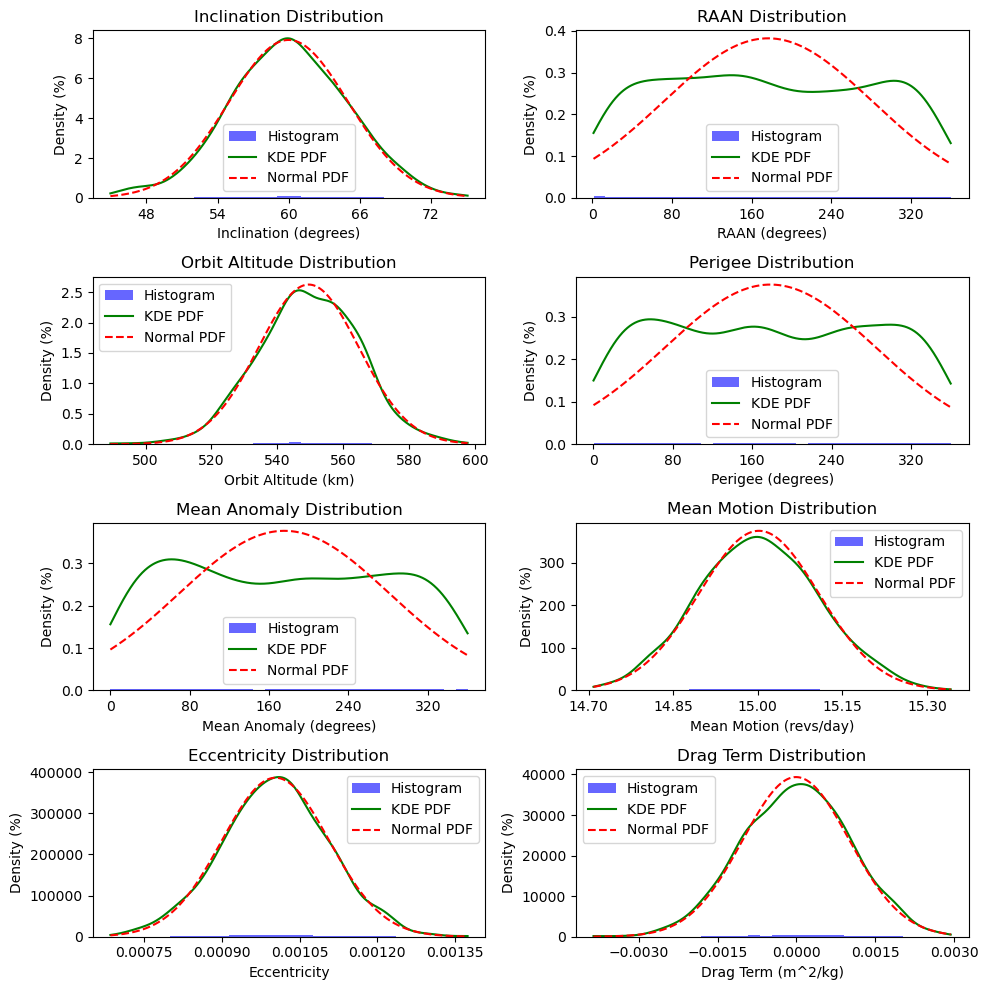

PDF Plots generated for Inclination, RAAN, Orbit Altitude, Perigee, Mean Anomaly, Mean Motion, Eccentricity, Drag Term.


In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm
from matplotlib.ticker import MaxNLocator

# Function to plot Histogram and PDF using Gaussian KDE and scipy.stats.norm
def plot_pdf(ax, data, title, xlabel):
    if len(data) == 0:
        print(f"No data available for {title}. Skipping plot.")
        return
    
    if not np.isfinite(data).all():
        print(f"Data contains NaN or infinite values for {title}. Skipping plot.")
        return
    
    # Calculate Gaussian KDE for comparison
    kde = gaussian_kde(data, bw_method='scott')
    x = np.linspace(min(data), max(data), 1000)
    kde_pdf = kde(x) * 100  # Convert to percentage if desired
    
    # Calculate Normal PDF based on data mean and std
    normal_pdf = norm.pdf(x, loc=np.mean(data), scale=np.std(data)) * 100
    
    # Plot the histogram
    ax.hist(data, bins=30, density=True, alpha=0.6, color='b', label='Histogram')
    
    # Plot the PDFs
    ax.plot(x, kde_pdf, 'g', label='KDE PDF')  # Gaussian KDE PDF
    ax.plot(x, normal_pdf, 'r', linestyle='--', label='Normal PDF')  # Normal PDF
    
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density (%)')
    ax.set_title(title)
    ax.legend()
    
    # Set x-axis tick locator to control tick density
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    
    ax.grid(False)

# Example usage (integrate this part into your main code)
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

# Replace the below example lists with your actual data
satellite_data = {
    'inclination': np.random.normal(60, 5, 1000),
    'raan': np.random.uniform(0, 360, 1000),
    'altitude': np.random.normal(550, 15, 1000),
    'perigee': np.random.uniform(0, 360, 1000),
    'mean_anomaly': np.random.uniform(0, 360, 1000),
    'mean_motion': np.random.normal(15, 0.1, 1000),
    'eccentricity': np.random.normal(0.001, 0.0001, 1000),
    'drag_term': np.random.normal(0, 0.001, 1000)
}

plot_pdf(axs[0, 0], satellite_data['inclination'], 'Inclination Distribution', 'Inclination (degrees)')
plot_pdf(axs[0, 1], satellite_data['raan'], 'RAAN Distribution', 'RAAN (degrees)')
plot_pdf(axs[1, 0], satellite_data['altitude'], 'Orbit Altitude Distribution', 'Orbit Altitude (km)')
plot_pdf(axs[1, 1], satellite_data['perigee'], 'Perigee Distribution', 'Perigee (degrees)')
plot_pdf(axs[2, 0], satellite_data['mean_anomaly'], 'Mean Anomaly Distribution', 'Mean Anomaly (degrees)')
plot_pdf(axs[2, 1], satellite_data['mean_motion'], 'Mean Motion Distribution', 'Mean Motion (revs/day)')
plot_pdf(axs[3, 0], satellite_data['eccentricity'], 'Eccentricity Distribution', 'Eccentricity')
plot_pdf(axs[3, 1], satellite_data['drag_term'], 'Drag Term Distribution', 'Drag Term (m^2/kg)')

plt.tight_layout()
plt.show()

print('PDF Plots generated for Inclination, RAAN, Orbit Altitude, Perigee, Mean Anomaly, Mean Motion, Eccentricity, Drag Term.')


E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


The maximum value of the PDF is: 13805.20059291844


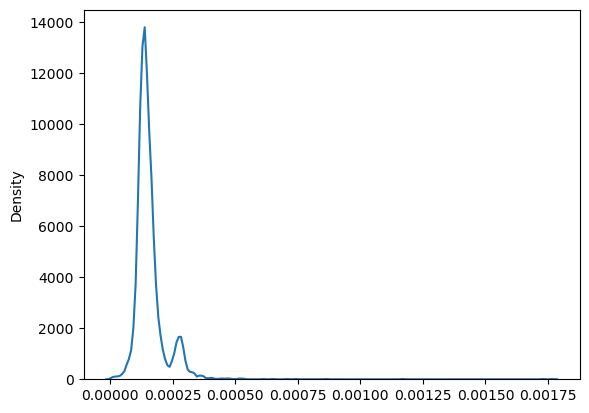

In [96]:
import numpy as np
import seaborn as sns

# 假设 eccentricities 是你的数据集
# eccentricities = [你的数据]

# 使用 seaborn 的 kdeplot 函数计算密度估计
kde = sns.kdeplot(eccentricities, bw_adjust=0.5)

# 获取 x 和 y 轴数据
x, y = kde.get_lines()[0].get_data()

# 计算 y 的最大值
max_pdf = np.max(y)

print(f"The maximum value of the PDF is: {max_pdf}")


In [95]:
len(eccentricities)

5074